<a href="https://colab.research.google.com/github/thienluc2017/fraud-detection/blob/main/1902124_CART_v%C3%A0_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive     
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd  
import numpy as np    
identity = pd.read_csv('/content/drive/MyDrive/data/train_identity.csv')  

In [ ]:
print(f'identity has {identity.shape[0]} rows and {identity.shape[1]} columns')   

identity has 144233 rows and 41 columns


In [ ]:
transaction = pd.read_csv('/content/drive/MyDrive/data/train_transaction.csv') 

In [ ]:
print(f'transaction has {transaction.shape[0]} rows and {transaction.shape[1]} columns')  

transaction has 590540 rows and 394 columns


In [ ]:
train = pd.merge(transaction,identity, on ='TransactionID', how='left')   

In [ ]:
print(f'train data has {train.shape[0]} rows and {train.shape[1]} columns')  

train data has 590540 rows and 434 columns


In [ ]:
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

In [ ]:
train['transaction_day'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)

In [ ]:
null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]

In [ ]:
for i in train.columns:
    if train[i].dtypes=='int64' or train[i].dtypes=='float64':   
        train[i].fillna(train[i].mean(),inplace=True)

In [ ]:
for i in train.columns:
    if train[i].dtypes=='object':     
        train[i].fillna(train[i].mode()[0],inplace=True)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
cat_cols = ['id_12','id_15', 'id_16', 'id_23', 
            'id_27', 'id_28', 'id_29','id_30', 'id_31', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in cat_cols:
  if i in train.columns:
    train[i] = le.fit_transform(train[i].astype(str).values)

In [ ]:
train_vcol =[]
for i in range(1,340):
  train_vcol.append('V'+str(i))
vcol=train[train_vcol]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(vcol)
  

PCA(n_components=3)

In [ ]:
vcol1=pca.transform(vcol)
train.drop(vcol,axis=1,inplace=True)
vcol1 = pd.DataFrame(vcol1)
train=pd.concat([train,vcol1],axis=1)
train = reduce_mem_usage(train)

Mem. usage decreased to 107.00 Mb (76.5% reduction)


In [ ]:
y= train['isFraud']
print(y.shape)

(590540,)


In [ ]:
x = train.drop(['isFraud','TransactionID','TransactionDT'],axis=1)
print(x.shape)

(590540, 97)


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify = y,test_size = 0.3, random_state=1)

CART

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=1)
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


DecisionTreeRegressor(random_state=1)

In [ ]:
predict = model.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from sklearn.metrics import roc_auc_score,confusion_matrix
roc_auc_score(y_test,predict)

0.7736764723009619

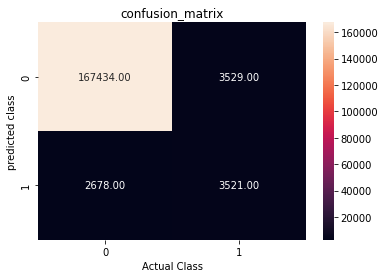

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,predict)
sns.heatmap(cm,annot=True,fmt='.2f')
plt.title('confusion_matrix')         
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
model=RandomForestRegressor(n_estimators = 1000,random_state=1)
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
predict = model.predict(x_test)

In [ ]:
roc_auc_score(y_test,predict)